<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/StableDiffusion_LatentSpace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A walk through Stable Diffusion's Latent Space

This notebook will implement the Keras tutorial [A walk through latent space with Stable Diffusion](https://keras.io/examples/generative/random_walks_with_stable_diffusion/). As explained in my notebook [StableDiffustion_Text2Image](https://github.com/AdamClarkStandke/GenerativeDeepLearning/blob/main/StableDiffustion_Text2Image.ipynb) what seperates Stable Diffusion from other text to image multi-modal models such as DALL.E and Imagen is that **Stable Diffusion wraps a Variational Auto-Encoder (VAE) over a Diffusion Model so that the training of the Diffusion Model takes place in the latent space**. The reason that this change is **so important** is that instead of doing the diffusion and reverse diffusion process in image/pixel space, the diffusion and reverse diffusion process takes place in a low dimensional latent space known as **Z**. When using a downsampling factor of 8 a 512x512x3 image is reduced to a 64x64x3 image allowing the diffusion and reverse diffusion process to take place in a 8,192 dimensional space rather than a 786,432 dimensional space!!!! Saving *signficant* computational time and resources when generating images with Diffusion Models; since Diffusion Models are notorious for being hard to train. As the authors of [Stable Diffusion](https://arxiv.org/pdf/2112.10752.pdf) state:

> Recently, Diffusion Probabilistic Models (DM)...have achieved state-of-the-art results in **density estimation**... [e]valuating and optimizing these models in pixel space, however, has the downside of low inference speed and **very high training costs...training on high-resolution image data always requires to calculate expensive gradients**.

Because the latent space **Z** is a [gaussian](https://en.wikipedia.org/wiki/Gaussian_curvature) constrained [manifold](https://en.wikipedia.org/wiki/Manifold#Differentiable_manifolds) even though we are dealing with a 8,192 dimensional space the feature vectors in this space should be normally distributed. Or in other words, similiar feature vectors should be near each other. As the authors of [A walk through latent space with Stable Diffusion](https://keras.io/examples/generative/random_walks_with_stable_diffusion/) state:

> Gernerative image models [such as Variational Auto-Encoders, Generative Adversarial Networks and Latent Diffusion Models(Stable Diffusion)] **learn a latent manifold of the visual world**...[which is a semi] low-dimensional vector space where each point [i.e. vector from **Z**] maps to an image [found in pixel space]...**[t]his latent manifold of image [features] is continuous and interpolative meaning that:**

> 1.   **Moving a little on the manifold only changes the corresponding [features of an] image a little**; and

> 2.   **For any two points A and B on the manifold [representing the features of] any two images, it is possible to move from A to B via a path where each intermediate point is also on the manifold (i.e. it is also a valid image [feature])**.

Accordingly, by exploring the latent space **Z** (and depending on the labels and features associated with the [images/dataset](https://github.com/AdamClarkStandke/GenerativeDeepLearning/blob/main/VAE.ipynb)) the latent representation of an input image can take on features of a neighboring image!!!   

As the authors of [A walk through latent space with Stable Diffusion](https://keras.io/examples/generative/random_walks_with_stable_diffusion/) state:

> **Latent space walking**, or **latent space exploration**, is the process of **sampling a point in latent space and incrementally changing the latent representation.** Its most common application is generating animations where each sampled point is fed to the decoder and is stored as a frame in the final animation. For high-quality latent representations, this produces coherent-looking animations. These animations can provide insight into the **feature map of the latent space**, and can ultimately lead to improvements in the training process.

So lets explore this space!!!! 🗺

---










## Interpolating between text prompts (i.e. interpolating between images)

Unlike the latent space created in the [VAE notebook](https://github.com/AdamClarkStandke/GenerativeDeepLearning/blob/main/VAE.ipynb) in which the latent space only consisted of image features, Stable Diffusion is a multi-modal model. In which text is used to guide the de-noising process (i.e. generating images). **Stable Diffusion combines these two latent manifolds to create one latent space.** As the authors of [A walk through latent space with Stable Diffusion](https://keras.io/examples/generative/random_walks_with_stable_diffusion/) state:

> Stable Diffusion isn't just an image model, though, it's also a natural language model. **It has two latent spaces: the image [latent] space learned by the encoder used during training, and the [text] latent space which is learned using a combination of pretraining and training-time fine-tuning.**

> In Stable Diffusion, a text prompt is first encoded into a vector, and that encoding is used to guide the diffusion process. The latent encoding vector has shape 77x768 (that's huge!), and when we give Stable Diffusion a text prompt, we're generating images from just one such point on the latent manifold.

In the [notebook](https://github.com/AdamClarkStandke/GenerativeDeepLearning/blob/main/StableDiffustion_Text2Image.ipynb) I detailed how the authors of [Stable Diffusion](https://arxiv.org/pdf/2112.10752.pdf) trained their Variational Auto-Encoder, the total expected loss and the training specs for text-to-image modeling. I did not detail the conditional mechanisms and training the Diffusion Model in the latent space. I will do it now.



---


### Conditional Mechanism:

In regards to the conditional mechanism the authors of [Stable Diffusion](https://arxiv.org/pdf/2112.10752.pdf) state:

> Similar to other types of generative models...diffusion models are in principle capable of modeling conditional distributions of the form $p(z|y)$. This can be implemented with a conditional denoising autoencoder $ϵ_θ(z_t, t, y)$ and paves the way to controlling the synthesis process through inputs *y* such as text


> To pre-process y from various modalities (such as language prompts) we introduce a domain specific encoder $τ_θ$ that projects *y* to an intermediate representation $τ_θ(y)∈ℝ^{M × d_τ}$ which is then mapped to the intermediate
layers of the [UNet](https://paperswithcode.com/method/u-net) via a cross-attention layer implementing Attention(*Q*, *K*, *V*) = $softmax(\frac{QK^T}{\sqrt{d}})⋅V$ with

\begin{align} Q = W^{(i)}_{Q}⋅ϕ_{i}(z_{t}), K=W^{(i)}_{K}⋅τ_{θ}(y), V=W^{(i)}_{V}⋅τ_{θ}(y) \end{align}

> Here $ϕ_{i}(z_{t})∈ℝ^{N×d^{i}_{ϵ}}$ denotes a (flattened) intermediate
> representation of the UNet [i.e. $ϵ_θ$]...and $W^{(i)}_{Q}, W^{(i)}_{K}, W^{(i)}_{V}$ are learnable projection matricies



---



### DM training in Latent Space:

Training the DM model in latent space *depends on the type of latent space created by the Variational Auto-encoder*. For Stable Diffusion the authors regulariaze the latent space **Z** to be zero centered with a variance determined by a regularizing loss term (which is either based on Kullback-Leibler or vector quantization). I will only be discussing regularizing the latent space using a Kullback-Leibler term (since this is what I discussed when talking about the Auto-encoder loss in my notebook [StableDiffustion_Text2Image](https://github.com/AdamClarkStandke/GenerativeDeepLearning/blob/main/StableDiffustion_Text2Image.ipynb))  As the authors of [Stable Diffusion](https://arxiv.org/pdf/2112.10752.pdf) state in regards to training the DM  in Latent Space

> (i) For a KL-regularized latent space, we sample $z=E(x)=Ε_{μ}(x)+E_σ(x)⋅ϵ $ where $ϵ$~N(0,1). When rescaling the latent, we estimate the component-wise variance as the following:
\begin{align} σ^2 = \frac{1}{bchw}Σ_{b,c,h,w}(z^{b,c,h,w}-μ)^2 \end{align}

where b is batch size, c is channel size, h is the height downsampling factor, w is the width downsampling factor and $μ=\frac{1}{bchw}Σ_{b,c,h,w}z^{b,c,h,w}$.

> **The output of $Ε$ is scaled such that the rescaled latent has unit standard deviation**, i.e. $z←\frac{z}{σ}=\frac{E(x)}{σ}=\frac{Ε_{μ}(x)+E_σ(x)⋅ϵ}{σ}$












---


Code:

In [1]:
!pip install keras-cv==0.6.0 -q
!pip install -U tensorflow -q
!pip install keras-core -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.3/756.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.6 MB/s eta 0:00:00


In [2]:
from textwrap import wrap
import os
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras
from keras_core import ops
from PIL import Image
import math

# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

Using TensorFlow backend
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [3]:
prompt_1 = "A still life drawing of a man in a black suit at the beach"  # promt for image A
prompt_2 = "A still life DSLR photo of a man in a black suit at the beach" # promt for image B
interpolation_steps = 5 # num of interpolation steps to take in the text based latent manifold

encoding_1 = ops.squeeze(model.encode_text(prompt_1)) # removes axis of one
encoding_2 = ops.squeeze(model.encode_text(prompt_2))

interpolated_encodings = ops.linspace(encoding_1, encoding_2, interpolation_steps)

# Size of the text based latent manifold
print(f"Shape of text based latent manifold: {encoding_1.shape}")

492466864/492466864 [==============================] - 4s 0us/step
Shape of text based latent manifold: (77, 768)


In [4]:
interpolated_encodings.shape

TensorShape([5, 77, 768])

In [5]:
'''The generate_image method is the combined process of text conditional
reverse-diffusion (i.e. denoising using the UNet architecture guided by text)
and decoding the latent matrix Z into an image'''

print(help(model.generate_image))

Help on method generate_image in module keras_cv.models.stable_diffusion.stable_diffusion:

generate_image(encoded_text, negative_prompt=None, batch_size=1, num_steps=50, unconditional_guidance_scale=7.5, diffusion_noise=None, seed=None) method of keras_cv.models.stable_diffusion.stable_diffusion.StableDiffusion instance
    Generates an image based on encoded text.
    
    The encoding passed to this method should be derived from
    `StableDiffusion.encode_text`.
    
    Args:
        encoded_text: Tensor of shape (`batch_size`, 77, 768), or a Tensor
            of shape (77, 768). When the batch axis is omitted, the same
            encoded text will be used to produce every generated image.
        batch_size: int, number of images to generate, defaults to 1.
        negative_prompt: a string containing information to negatively guide
            the image generation (e.g. by removing or altering certain
            aspects of the generated image), defaults to None.
        num_s

In [5]:
seed = 12345
noise = tf.random.normal((512 // 8, 512 // 8, 4))

# images = model.generate_image(
#     interpolated_encodings,
#     batch_size=interpolation_steps,
#     diffusion_noise=noise,
# )

In [3]:
def export_as_gif(filename, images, frames_per_second=30, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )


# export_as_gif(
#     "doggo-and-fruit-5.gif",
#     [Image.fromarray(img) for img in images],
#     frames_per_second=2,
#     rubber_band=True,
# )

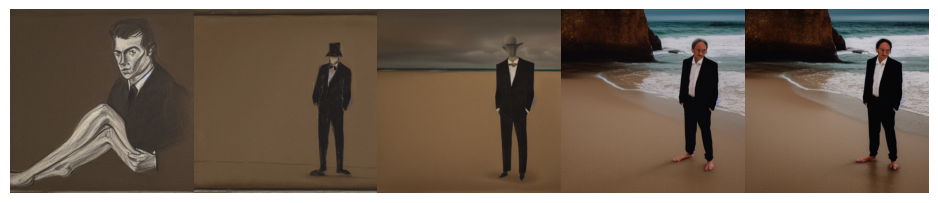

In [11]:
def plot_grid(images, path, grid_size, scale=2):
    fig, axs = plt.subplots(
        grid_size, grid_size, figsize=(grid_size * scale, grid_size * scale)
    )
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")
    for ax in axs.flat:
        ax.axis("off")

    images = images.astype(int)
    for i in range(min(grid_size * grid_size, len(images))):
        ax = axs.flat[i]
        ax.imshow(images[i].astype("uint8"))
        ax.axis("off")

    for i in range(len(images), grid_size * grid_size):
        axs.flat[i].axis("off")
        axs.flat[i].remove()

    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )
plot_grid(images, "2-way-interpolation.jpg", interpolation_steps)

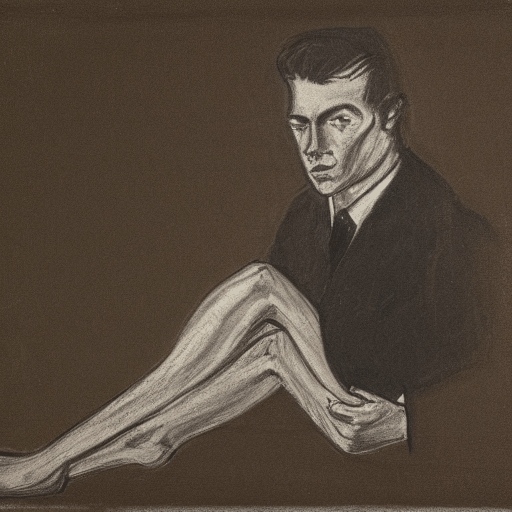

In [12]:
from IPython.display import Image as IImage
IImage("doggo-and-fruit-5.gif")

In [13]:
# Fined grained/coherent shift interpolation with 150 steps and batch size of 3
interpolation_steps = 150
batch_size = 3
batches = interpolation_steps // batch_size

interpolated_encodings = ops.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = ops.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]


25/25 [==============================] - 12s 504ms/step


In [7]:
def downsample(image):
  half = 0.5
  size = [int(half * s) for s in image.size]
  return image.resize(size)

# gif_maker = []
# for i in range(0,len(images)):
#   gif_maker.append(downsample(images[i]))

# export_as_gif("bowler_hat_man.gif", gif_maker, frames_per_second=2, rubber_band=True)

## Walking in Stable Baseline's Latent Space

As stated above the Stable BaseLine's Latent Space **Z** is composed of a text based latent manifold $z_{1}$ detailed by the encoder $τ_θ(y)$ where $z_{1}∈ℝ^{M\times d_{τ}}$ (which in this case *M*=77 the max token sequence length; $d_{τ}$=768 the dimension of the embedding vector) and an image based latent manifold $z_{2, T}$ detailed by the encoder $E(x)$ where $z_{2, T}∈ℝ^{H/h\times W/w \times c}$(which in this case H/h=64, W/w=64, and c=4 and **represents the random noise used during the diffusion process**). After concatenation of $z_{1} ǂ z_{2, T}$ Stable Baseline's Latent Space **Z** is the following: $z_{1} ǂ z_{2, T}∈Z$.

As the authors of [A walk through latent space with Stable Diffusion](https://keras.io/examples/generative/random_walks_with_stable_diffusion/) detail the **boundary** of the text based latent manifold $z_{1}$ can be approximated through the use of adusting the magnitude of the walking steps (i.e. the  step_size)

> Perhaps unsurprisingly, walking too far from the encoder's latent manifold produces images that look incoherent. Try it for yourself by setting your own prompt, and adjusting step_size to increase or decrease the magnitude of the walk. Note that when the magnitude of the walk gets large, the walk often leads into areas which produce extremely noisy images



In [8]:
walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size
step_size = 0.005

encoding = ops.squeeze(
    model.encode_text("The Arc de Triomphe de l'Étoile in the style of Saturn Devouring His Son")
)
# Note that (77, 768) is the shape of the text encoding.
delta = ops.ones_like(encoding) * step_size

walked_encodings = []
for step_index in range(walk_steps):
    walked_encodings.append(encoding)
    encoding += delta
walked_encodings = ops.stack(walked_encodings)
batched_encodings = ops.split(walked_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

gif_maker = []
for i in range(0,len(images)):
  gif_maker.append(downsample(images[i]))

export_as_gif("paris_at_night.gif", gif_maker, frames_per_second=10, rubber_band=True)

25/25 [==============================] - 12s 499ms/step


## Walking through the Diffusion Noise Space